## 17. 컴퓨터 비전

### 17.1. 합성곱 신경망

In [1]:
import MLDatasets 
import Flux, NNlib 
import Flux: onehotbatch 
import MLUtils: DataLoader 
import CUDA: has_cuda 
import Zygote, Optimisers 
import Formatting: printfmtln
using Random: MersenneTwister
import Plots
# 필요 데이터 자동 다운로드
ENV["DATADEPS_ALWAYS_ACCEPT"] = true;

패션 아이템 분류

16장과 공통 코드

In [2]:
function get_data(batchsize = 64)
    xtrain, ytrain = MLDatasets.FashionMNIST(:train)[:]
    xtest, ytest = MLDatasets.FashionMNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize=batchsize)
    test_loader = DataLoader((xtest, ytest),  batchsize=batchsize)
    
    return train_loader, test_loader
end

function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 300 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += size(X)[end]
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

init(rng) = Flux.glorot_uniform(rng)

function build_mlp_model(rng)
    Flux.Chain(
        Flux.flatten,
        Flux.Dense(28 * 28 => 512, NNlib.relu; init=init(rng)),
        Flux.Dense(512 => 512, NNlib.relu; init=init(rng)),
        Flux.Dense(512 => 10; init=init(rng)),
    )
end

build_mlp_model (generic function with 1 method)

간단한 합성곱 신경망 모델

In [3]:
function build_cnn_model(rng)
    same = Flux.SamePad()
    Flux.Chain(
        Flux.Conv((3,3),  1 => 32, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (28 x 28) => (14 x 14)
        Flux.Conv((3,3), 32 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (14 x 14) => (7 x 7)
        Flux.Conv((3,3), 64 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (7 x 7) => (3 x 3)
        Flux.flatten,
        Flux.Dense(3 * 3 * 64 => 64, NNlib.relu; init=init(rng)),
        Flux.Dense(64 => 10; init=init(rng)),
    )
end

build_cnn_model (generic function with 1 method)

합성곱 + 드랍아웃 + 배치 정규화

In [4]:
function build_cnn2_model(rng)
    same = Flux.SamePad()
    Flux.Chain(
        Flux.Conv((3,3),  1 => 32, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (28 x 28) => (14 x 14)
        Flux.Dropout(0.2),
        Flux.BatchNorm(32),

        Flux.Conv((3,3), 32 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (14 x 14) => (7 x 7)
        Flux.Dropout(0.2),
        Flux.BatchNorm(64),
        
        Flux.Conv((3,3), 64 => 64, NNlib.relu, pad=same; init=init(rng)),
        Flux.MaxPool((2,2)), # (7 x 7) => (3 x 3)        
        Flux.Dropout(0.2),
        Flux.BatchNorm(64),
        
        Flux.flatten,
        Flux.Dense(3 * 3 * 64 => 64, NNlib.relu; init=init(rng)),    
        Flux.Dropout(0.2),
        Flux.Dense(64 => 10; init=init(rng)),
    )
end

build_cnn2_model (generic function with 1 method)

복수 모델 일괄 실행

In [5]:
function run_batch(loaders, models, epochs)
    train_loader, test_loader = loaders
    loss_fn(m, x, y) = Flux.Losses.logitcrossentropy(m(x), y)
    train_losses, accuracies = [], []
    for (k, model) in enumerate(models)
        train_loss, accuracy = [], []
        optimizer = Optimisers.setup(Optimisers.Adam(), model)
        for t in 1:epochs
            println("[Model $k] Epoch $t")
            println("-------------------------------")
            model, optimizer, losses = train(train_loader, model, loss_fn, optimizer)
            train_loss = vcat(train_loss, losses)
            acc, _ = test(test_loader, model, loss_fn)
            push!(accuracy, acc)
        end
        push!(train_losses, train_loss)
        push!(accuracies, accuracy)
    end
    train_losses, accuracies
end

run_batch (generic function with 1 method)

In [6]:
rng = MersenneTwister(1)
models = [build_mlp_model(rng), build_cnn_model(rng), build_cnn2_model(rng)] 
models = models .|> Flux.gpu

epochs = 30
train_losses, accuracies = run_batch(get_data(), models, epochs);

[Model 1] Epoch 1
-------------------------------
[Train] loss: 0.3222164 [300/938]
[Train] loss: 0.3273117 [600/938]
[Train] loss: 0.3015752 [900/938]
[Test] Accuracy: 85.5, Avg loss: 0.4073029
[Model 1] Epoch 2
-------------------------------
[Train] loss: 0.2623849 [300/938]
[Train] loss: 0.2649896 [600/938]
[Train] loss: 0.2662548 [900/938]
[Test] Accuracy: 85.4, Avg loss: 0.3886308
[Model 1] Epoch 3
-------------------------------
[Train] loss: 0.2253338 [300/938]
[Train] loss: 0.2318315 [600/938]
[Train] loss: 0.2525610 [900/938]
[Test] Accuracy: 85.7, Avg loss: 0.3813728
[Model 1] Epoch 4
-------------------------------
[Train] loss: 0.2217804 [300/938]
[Train] loss: 0.2040034 [600/938]
[Train] loss: 0.2320966 [900/938]
[Test] Accuracy: 86.1, Avg loss: 0.3794733
[Model 1] Epoch 5
-------------------------------
[Train] loss: 0.2048267 [300/938]
[Train] loss: 0.1683281 [600/938]
[Train] loss: 0.1885462 [900/938]
[Test] Accuracy: 86.6, Avg loss: 0.3588563
[Model 1] Epoch 6
-------

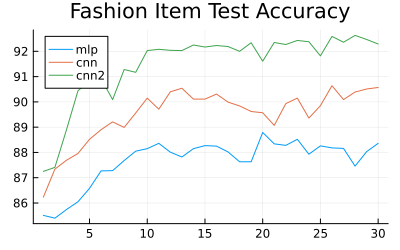

In [7]:
Plots.gr(size=(400,250))
label = ["mlp" "cnn" "cnn2"]
title = "Fashion Item Test Accuracy"
Plots.plot(1:epochs, accuracies, label=label, title=title)

숫자 손글씨 분류

In [8]:
function get_mnist_data(batchsize = 64)
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    xtrain = reshape(xtrain, 28, 28, 1, :)
    xtest = reshape(xtest, 28, 28, 1, :)

    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    train_loader = DataLoader((xtrain, ytrain), batchsize=batchsize)
    test_loader = DataLoader((xtest, ytest),  batchsize=batchsize)
    
    return train_loader, test_loader
end

get_mnist_data (generic function with 2 methods)

In [9]:
rng = MersenneTwister(1)
models = [build_mlp_model(rng), build_cnn_model(rng), build_cnn2_model(rng)] 
models = models .|> Flux.gpu

epochs = 30
train_losses, accuracies = run_batch(get_mnist_data(), models, epochs);

[Model 1] Epoch 1
-------------------------------
[Train] loss: 0.0820082 [300/938]
[Train] loss: 0.1160886 [600/938]
[Train] loss: 0.0680300 [900/938]
[Test] Accuracy: 95.4, Avg loss: 0.1427165
[Model 1] Epoch 2
-------------------------------
[Train] loss: 0.0271692 [300/938]
[Train] loss: 0.0274327 [600/938]
[Train] loss: 0.0402313 [900/938]
[Test] Accuracy: 97.0, Avg loss: 0.0973027
[Model 1] Epoch 3
-------------------------------
[Train] loss: 0.0197965 [300/938]
[Train] loss: 0.0284775 [600/938]
[Train] loss: 0.0135472 [900/938]
[Test] Accuracy: 97.4, Avg loss: 0.0951010
[Model 1] Epoch 4
-------------------------------
[Train] loss: 0.0125373 [300/938]
[Train] loss: 0.0158667 [600/938]
[Train] loss: 0.0152917 [900/938]
[Test] Accuracy: 97.6, Avg loss: 0.0940651
[Model 1] Epoch 5
-------------------------------
[Train] loss: 0.0088648 [300/938]
[Train] loss: 0.0214824 [600/938]
[Train] loss: 0.0103437 [900/938]
[Test] Accuracy: 97.0, Avg loss: 0.1207490
[Model 1] Epoch 6
-------

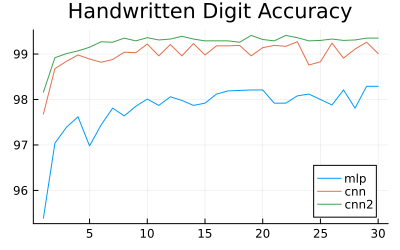

In [10]:
Plots.gr(size=(400,250))
label = ["mlp" "cnn" "cnn2"]
title = "Handwritten Digit Accuracy"
Plots.plot(1:epochs, accuracies, label=label, title=title)